In [2]:
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Toggle Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

In [39]:
from scipy.spatial.distance import cdist
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova, DistanceMatrix
from umap import UMAP
from friendly_guacamole.datasets import (
    Dataset,
    QiitaTable,
    QiitaMetadata,
    GreenGenes97Tree,
    TableList,
)
from friendly_guacamole.transforms import (
    UniFrac,
    CLR,
    AsDense,
    RarefactionBIOM,
    PCoA,
    FilterSamples,
)
import matplotlib
import matplotlib.pyplot as plt

In [4]:
class StorageStudy16S(Dataset):
    study_id = 10394
    table_artifact_id = 45307

    artifacts = {
        'metadata': QiitaMetadata(study_id),
        'table': QiitaTable(table_artifact_id),
        'tree': GreenGenes97Tree(),
    }

In [5]:
# class StorageStudyMG(Dataset):
#     study_id = 10394
#     table_artifact_ids = []

#     artifacts = {
#         'metadata': QiitaMetadata(study_id),
#         'table': TableList(table_artifact_ids),
#         'tree': GreenGenes97Tree(),
#     }

In [6]:
RAREFACTION_DEPTH = 10000
dataset = StorageStudy16S('data/storage-16S')

Files already downloaded and verified


In [7]:
table = dataset['table']
tree = dataset['tree']


In [8]:
metadata = dataset['metadata'].set_index('sample_name')
y = metadata.loc[table.ids('sample')]
hue_ids = [f'D{i}' for i in range(1, 6)] + [f'H{i}' for i in range(1, 11)]
keep_samples = y['host_subject_id'].isin(hue_ids)
keep_ids = y.index[keep_samples]
table = table.filter(keep_ids, inplace=False)


In [9]:
# y['sample_storage_temp_treatment'].value_counts()
y['fresh'] = (y['duration_of_storage'] == 'fresh')

In [10]:
preprocessing = Pipeline([
    ('filter_samples', FilterSamples(RAREFACTION_DEPTH))
])

table = preprocessing.fit_transform(table)

In [31]:
y = y.loc[table.ids('sample')]
y['human'] = y['host_subject_id'].str.startswith('H')

In [32]:
y['human'].value_counts()


True     866
False    413
Name: human, dtype: int64

In [12]:
table.sum('sample').shape

(1279,)

In [13]:
# unifrac_method='weighted_unnormalized'
unifrac_method='unweighted'
dm_pipeline = Pipeline([
    ('subsample', RarefactionBIOM(RAREFACTION_DEPTH)),
    ('unifrac', UniFrac(dataset.apply('tree', 'path'),
#                         unifrac_method='weighted_unnormalized',
                        unifrac_method=unifrac_method,
                        )),
])
dm = dm_pipeline.fit_transform(table)

In [35]:
permanova(DistanceMatrix(dm), y['human'])

method name                PERMANOVA
test statistic name         pseudo-F
sample size                     1279
number of groups                   2
test statistic            359.797628
p-value                        0.001
number of permutations           999
Name: PERMANOVA results, dtype: object

In [18]:
X = PCoA(metric='precomputed').fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.059749448720539285 and the largest is 61.78581524940085.
  warn(


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC1270,PC1271,PC1272,PC1273,PC1274,PC1275,PC1276,PC1277,PC1278,PC1279
0,-0.253415,-0.097472,-0.007558,-0.158876,-0.184789,0.079143,-0.014989,0.023169,-0.034759,-0.023580,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.232790,-0.093381,-0.034059,-0.228872,-0.209569,0.111442,-0.007543,0.025346,0.027549,-0.104530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.104059,-0.032010,-0.055056,-0.191310,-0.136090,0.098465,0.049179,-0.009426,0.027251,-0.047253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.071591,-0.119318,-0.138317,-0.186962,-0.064618,0.010776,-0.008123,-0.017402,0.006700,-0.065176,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.210031,-0.112334,-0.051700,-0.244986,-0.212238,0.107902,0.036257,0.030874,0.025513,-0.070643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,-0.398387,0.043438,0.058304,0.049075,0.014464,-0.003437,0.001754,-0.002787,0.010572,0.084674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1275,-0.349567,0.021810,0.028258,0.009489,-0.010439,-0.012517,-0.004940,-0.024428,-0.022049,0.084204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1276,-0.296519,0.006011,0.033461,-0.082456,0.003063,0.029807,0.071111,0.010963,-0.034081,0.030968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1277,-0.401535,0.044625,0.023229,0.005791,0.014569,0.011119,0.018005,0.005493,0.002228,0.084479,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
pc_dm = cdist(X.iloc[:, :2], X.iloc[:, :2])

In [33]:
permanova(DistanceMatrix(pc_dm), y['human'])

method name                 PERMANOVA
test statistic name          pseudo-F
sample size                      1279
number of groups                    2
test statistic            3274.690512
p-value                         0.001
number of permutations            999
Name: PERMANOVA results, dtype: object

In [53]:
neighbor_sizes = [5, 10, 20, 40, 80, 160, 320, 640]

In [59]:
all_results = {}
for n in neighbor_sizes:
    res_n = []
    for seed in range(5):
        min_dist = 1
        u_n = UMAP(metric='precomputed',
                   n_components=2,
                   random_state=seed,
                   min_dist=min_dist,
                   n_neighbors=n,
                   ).fit_transform(
                        dm
                   )

        # pc_dm = cdist(u_n[:, :2], u_n[:, :2])
        # res = permanova(DistanceMatrix(pc_dm), y['human'])
        svm = LinearSVC(
            C=1e10,
        )
        y_predictions = svm.fit(u_n, y['human']).predict(u_n)

        res = accuracy_score(y['human'], y_predictions)
        res_n.append(res)
    all_results[n] = res_n

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(
/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/garmstro/miniconda

In [60]:
all_results

{5: [0.9124315871774824,
  0.8342455043002346,
  0.9022673964034402,
  0.8678655199374511,
  0.7982799061767005],
 10: [0.4949179046129789,
  0.6121970289288506,
  0.5989053948397185,
  0.6364347146207975,
  0.6770914777169664],
 20: [0.7028928850664582,
  0.6770914777169664,
  0.8264268960125097,
  0.6403440187646599,
  0.6309616888193902],
 40: [0.856137607505864,
  0.9992181391712275,
  0.9405785770132916,
  0.9507427677873339,
  0.8021892103205629],
 80: [0.9374511336982018,
  1.0,
  0.8616106333072713,
  0.7349491790461298,
  0.7310398749022674],
 160: [0.9992181391712275,
  0.9992181391712275,
  0.9992181391712275,
  0.7740422204847537,
  0.8819390148553558],
 320: [0.9992181391712275,
  0.7920250195465207,
  0.962470680218921,
  0.7928068803752932,
  0.9992181391712275],
 640: [0.9992181391712275,
  0.9992181391712275,
  0.7208756841282252,
  0.9992181391712275,
  0.9992181391712275]}

In [61]:
{n: sum(l) / len(l) for n, l in all_results.items()}

{5: 0.8630179827990616,
 10: 0.6039093041438623,
 20: 0.6955433932759968,
 40: 0.909773260359656,
 80: 0.8530101641907739,
 160: 0.9307271305707584,
 320: 0.9091477716966381,
 640: 0.943549648162627}

In [57]:
n_neighbors=640
min_dist=1
U2 = UMAP(metric='precomputed', n_components=2, random_state=824, min_dist=min_dist, n_neighbors=n_neighbors).fit_transform(dm)

/home/garmstro/miniconda3/envs/umap-benchmarking/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


Two component

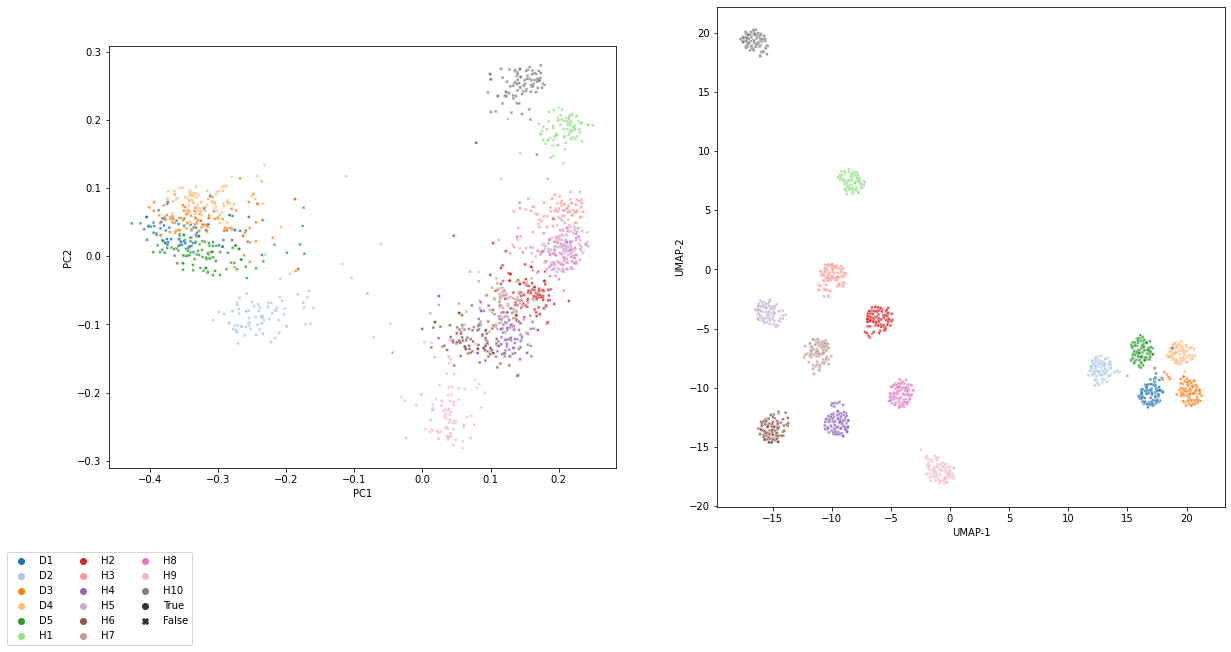

In [58]:
toggle_code()

hue_var = 'host_subject_id'
style_var = 'fresh'

noise_like = np.random.uniform(size=len(X['PC1']))
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
g0 = sns.scatterplot(
    x=X['PC1'],
    y=X['PC2'],
    # hue=y['period']
    hue=y[hue_var].tolist(),
    hue_order=hue_ids,
    palette='tab20',
    style=y[style_var].tolist(),
    style_order=[True, False],
    s=10,
    ax=axs[0],
#     legend=False,
)
axs[0].legend(bbox_to_anchor=(-0.2, -0.2), loc=2, borderaxespad=0., ncol=3)
# leg = g0.get_legend()
# leg.remove()
# plt.legend(loc='upper left')
# axs[1][0].set_legend(g0)
g0.set_ylabel('PC2')
g0.set_aspect('equal')
g1 = sns.scatterplot(
    x=pd.Series(U2[:, 0], name='UMAP-1'),
    y=pd.Series(U2[:, 1], name='UMAP-2'),
    hue=y[hue_var].tolist(),
    hue_order=hue_ids,
    palette='tab20',
    s=10,
    style=y[style_var].tolist(),
    style_order=[True, False],
    ax=axs[1],
    legend=False,
)
g1.set_aspect('equal')
plt.savefig(f'results/storage-study-{unifrac_method}-n_neighbors-{n_neighbors}-min_dist-{min_dist}-2d-embeddding.png', dpi=400)
plt.show()
